# House Prices: Advanced Regression Techniques

This notebook has been written by Davide Facchinelli, Davide Manfredini and Ilaria Servadio. It aims to solve the problem of predicting the price of a set of houses given their features, as proposed in the [homonym Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/).

# Analysis

Loading libraries required:

In [1]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from itertools import permutations
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams

## Import and cleaning

We read the dataset *'train'* as dataframes:

In [17]:
train = pd.read_csv("train.csv")
train_elem = len(train) # We save the number of rows of the dataframe in a variable

Reading the documentation of the [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf), we discover that there are potential pitfalls in the dataset. A scatter plot of *SalePrice* versus *GrLivArea* will indicate these outliers: we notice that two points are simply unusual sales. These two points represent very large houses priced relatively lower. Therefore, we decide to remove these two houses with more than 4000 square feet and sale price smaller than 300000 from the data set.

Text(0.5,1,'Scatter plot GrLivArea and SalePrice')

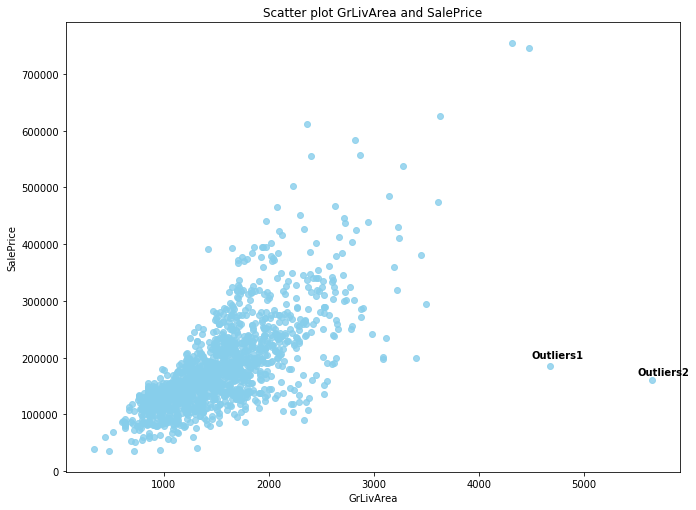

In [18]:
### Show the plot and we spot the two houses to remove ###

# figure size in inches
rcParams['figure.figsize'] = 11,8.27

# create plot
p1 = sns.regplot(data=train, x=train.GrLivArea, y=train.SalePrice, fit_reg=False, marker="o", color="skyblue")

# add text annotation
p1.text(4500+0.2, 200000, "Outliers1", horizontalalignment='left', size='medium', color='black', weight='semibold')
p1.text(5999, 170000, "Outliers2", horizontalalignment='right', size='medium', color='black', weight='semibold')

# add title
ax = plt.gca()
ax.set_title("Scatter plot GrLivArea and SalePrice")

As mentioned above, we remove the identified outliers:

In [19]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

Having examined *GrLivArea* based on *SalePrice* and having find few outliers, we decided to follow this strategy and plot several features versus *SalePrice* to see if there are some other outliers or find some more information. However, to improve the readability we decide not to include all the analysis and plots that we did but just the more outstanding.  
Below, we show two plots: one relating to the relationship between *OverallQual* and *SalePrice* in training set and the other relating to changes introduced by us.   

In the blue plot, is represented the relationship between the finish quality and the selling price of the houses. It should also be noted that:
- there are two houses belonging to category 10 but they are far away from the others in the same category. Its price is even higher than 700000 dollars. That is why we opted for create a new category in which there will be all the houses that prices are higher than 700000 and previously they were placed in a category between nine and ten;
- we identify outliers that therefore we want to remove.  

In the red plot you can see what happens to those two houses after introducing a new category.

Text(0.5,1,'OverallQual and SalePrice: with a new category')

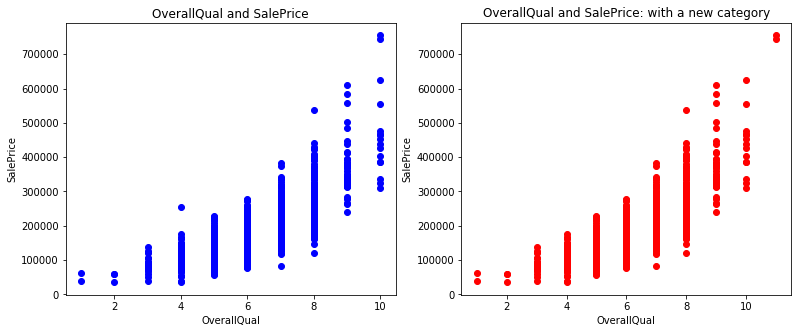

In [20]:
train1 = train
train1 = train1.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train1.loc[train[(train['OverallQual'] > 9)&(train['SalePrice']>700000)].index,'OverallQual'] = 11

plt.figure(figsize=(13,11))
plt.subplot(2, 2, 1)
plt.scatter(train['OverallQual'],train['SalePrice'],c = 'b')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual and SalePrice')

plt.subplot(2, 2, 2)
plt.scatter(train1['OverallQual'],train1['SalePrice'], c = 'r')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual and SalePrice: with a new category')

In succession, we delete pitfalls and we include the new category.

In [21]:
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train.loc[train[(train['OverallQual'] > 9)&(train['SalePrice']>700000)].index,'OverallQual'] = 11

A further analysis concerns the report between the overall condition of the house (*OverallCond*) and *SalePrice*. What we found are spurious data: 

- there are few houses which the price are higher than 700000 dollars but the overall condition of the house is lower than that have better conditions;
- there is one house which the price are higher than 300000 dollars but the condition of the house is very low.

Text(0.5,1,'Scatter plot OverallCond and SalePrice')

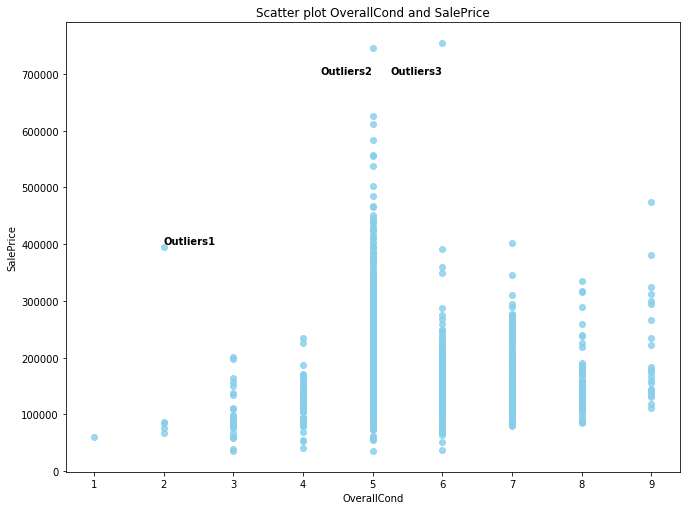

In [22]:
# figure size in inches
rcParams['figure.figsize'] = 11,8.27

# create plot
p2 = sns.regplot(data=train, x=train.OverallCond, y=train.SalePrice, fit_reg=False, marker="o", color="skyblue")

# add text annotation
p2.text(2, 400000, "Outliers1", horizontalalignment='left', size='medium', color='black', weight='semibold')
p2.text(5, 700010, "Outliers2", horizontalalignment='right', size='medium', color='black', weight='semibold')
p2.text(6, 700000, "Outliers3", horizontalalignment='right', size='medium', color='black', weight='semibold')

# add title
ax = plt.gca()
ax.set_title("Scatter plot OverallCond and SalePrice")

Now is the time to remove from the train everything that has been said.

In [23]:
train = train.drop(train[(train['OverallCond']<7) & (train['SalePrice']>700000)].index)
train = train.drop(train[(train['OverallCond']<4) & (train['SalePrice']>300000)].index)

In [24]:
train.to_csv('train_no_outliers.csv') # Save the result into csv file for a future use (svm)

In the next step what we will do is to :

- Save the *Id* and *SalePrice* columns from the train in a new dataframe for future use;
- Delete the *SalePrice* colum from the train;
- Read the dataset *test* as dataframes;
- Merge into a single dataframe train and set.

In [25]:
prices = pd.DataFrame(train[['Id','SalePrice']])
train = train.drop(columns=['SalePrice'])

test = pd.read_csv('test.csv')

total = pd.concat([train,test])

**Dealing with ordinal predictors**

A categorical variable has two or more categories but there is no ordering to the categories and there is no agreed way to order these from highest to lowest.  An ordinal variable is similar to a categorical variable but the difference between the two is that, in ordinal variable, there is a clear ordering of the variables.  

In the data set certain ordinal predictors at first are stored as factors. What was the strategy adopted?

- Consider a variable like *ExterQual* (with values such as Excellent, Good, Average/Typical, Fair, Poor). In addition to being able to classify houses into these values, we decide to order the categories from 0 to 4. We repeated this step for all the variables for which it was necessary.
- Thanks to the function *transformer* (which can be found at the end of this notebook) we apply the changes to all the following variables.

In [26]:
QualToIntVoc = {'Ex':0, 'Gd':1, 'TA':2,'Fa':3,'missing':4}
QualCol = ['ExterQual','ExterCond','KitchenQual','HeatingQC','BsmtQual','BsmtCond','FireplaceQu','GarageQual','PoolQC']
for c in QualCol:
    total[c] = total[c].apply(lambda x: transformer(x,QualToIntVoc, 5))
    
SlopeToIntVoc = {'Gtl' : 0, 'Mod':1,'Sev':2}
SlopeCol = ['LandSlope','CentralAir','Street','PavedDrive']
for c in SlopeCol:
    total[c] = total[c].apply(lambda x: transformer(x,SlopeToIntVoc, 3))
    
GFinishToIntVoc = {'Fin':0,'RFn':1,'Unf':2}
total['GarageFinish'] = total['GarageFinish'].apply(lambda x: transformer(x,GFinishToIntVoc, 3))

BsmtExposureToIntVoc = {'Gd':0,'Av':1,'Mn':2,'No':3}
total['BsmtExposure'] = total['BsmtExposure'].apply(lambda x: transformer(x,BsmtExposureToIntVoc, 4))

FunctionalToIntVoc = {'Typ':0,'Min1':1,'Min2':1}
total['Functional_int'] = total['Functional'].apply(lambda x: transformer(x,FunctionalToIntVoc, 3))

HouseStyleToIntVoc = {'1.5Unf':0,'SFoyer':1,'1.5Fin':2,'2.5Unf':3,'SLvl':4,'1Story':5,'2Story':6,'2.5Fin':7}
total['HouseStyle_int'] = total['HouseStyle'].apply(lambda x: transformer(x,HouseStyleToIntVoc, 8))
total['HouseStyle_1st'] = 1*(total['HouseStyle'] == '1Story')
total['HouseStyle_2st'] = 1*(total['HouseStyle'] == '2Story')
total['HouseStyle_15st'] = 1*(total['HouseStyle'] == '1.5Fin')
total = total.drop(columns = ['HouseStyle'])

FoundationToIntVoc = {'PConc':3,'CBlock':2,'BrkTil':1}
total['Foundation_int'] = total['Foundation'].apply(lambda x: transformer(x,FoundationToIntVoc, 0))

MasVnrTypeToIntVoc = {'Stone':3,'BrkFace':2,'BrkCmn':1}
total['MasVnrType_int'] = total['MasVnrType'].apply(lambda x: transformer(x,MasVnrTypeToIntVoc, 0))

BsmtFinType1ToIntVoc = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
total['BsmtFinType1_int'] = total['BsmtFinType1'].apply(lambda x: transformer(x,BsmtFinType1ToIntVoc, 0))

Another anomaly that has immediately occurred to us is that some years of construction are wrong. In fact, they are present years to come! We decided to solve this iusse by changing all the wrong years.

In [27]:
total['GarageYrBlt'] = total['GarageYrBlt'].apply(lambda x:x if x < 2018 else 2007)

To improve the fitting for linear model, we add some squared prediction, we assume that similar non-linearities will also hold when we add predictor to multi-dimensional model. This will do after

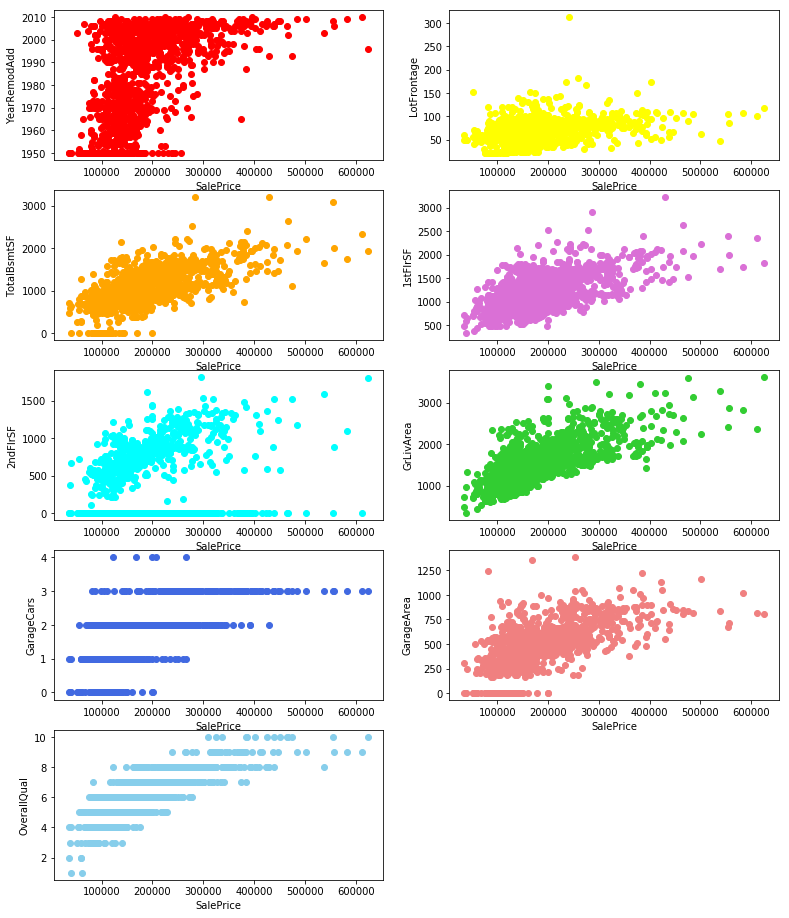

In [28]:
plotter2()

Columner() is a function that return a triplet containing the columns of a dataframe, as the numeric and non numeric columns. We have created this function because it helps us to take into account, after each change, how many columns are numeric and how many are not. 

In [29]:
col, numCol, nonNumCol = columner(total)

**One-hot encoding on categorical data:**

We can not work directly with categorical data and therefore we must somehow convert our categorical data to numbers. After that, the task of one-hot encoder is to encode categorical integer features as a one-hot numeric array.

In [30]:
total = oneHotter(total,nonNumCol)

In [31]:
total.to_csv('total_to_be_miced.csv') # Save the result into csv file for dealing with missing values

**Imputing Missing Data with R**

The mice package implements a method to deal with missing data because leaving out available datapoints deprives the data of some amount of information.  
Before applying this approach, we try to replace the missing values with the means and with the median. However, the best strategy was to impute missing value with *MICE* package. In fact, for example, applying mean-substitution leaves the mean unchanged and this is good but decreases variance which may be undesirable.  
MICE helps us imputing missing data with plausible data values which are drawn from a distribution specifically designed for each missing datapoint.

At this point, we are reading the new dataset obtained thanks *'MICE'* as dataframe and we remove the columns that correspond to the indexes added when saving the dataframe in a file:

In [32]:
total = pd.read_csv('total_mice_rf.csv')

In [33]:
total = total.drop(columns=['Unnamed: 0','X'])

In [34]:
col, numCol, nonNumCol = columner(total)
#Again, we use columner () to see how columns are divided between numeric and non-numerical in our data frame

At this point we analyze the possible simmetry or asymmetry of the distribution of each feature. To do this, we analyze the _skewness_ of all features, that is a measure of the asymmetry of a distribution. For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. A zero value means that the tails on both sides of the mean balance out overall; this is the case for a symmetric distribution, but can also be true for an asymmetric distribution where one tail is long and thin, and the other is short but fat. For positive skewness say that a distribution is not normal, but in this case is possible to transform the distribution in a normal distribution. Just apply the logarithm function to each column with high skewness. We choose as threshold the value $0.75$

In [35]:
total,skewed = deskewer(total,numCol)

In [36]:
if skew(prices['SalePrice'], nan_policy='omit')>0.75:
    prices['SalePrice'] = np.log1p(prices['SalePrice'])
    skewed.append('SalePrice')

To improve the fitting for linear model, we add some squared prediction, we assume that similar non-linearities will also hold when we add predictor to multi-dimensional model.

In [37]:
toSquare = ['YearRemodAdd', 'LotFrontage', 'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'OverallQual']
for f in toSquare:
    total[f+'_square'] = total[f]*total[f]

In [38]:
col, numCol, nonNumCol = columner(total)

A possible problem can be given by the multicollinarity,In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. To avoid this problem, we analyze the correlation between each pair of features. For each couple of very correlated feature, we delete the feature that is less correleated with _SalePrice_

In [39]:
corrM = total.drop(columns = ['Id']).corr()
coltemp = list(corrM.columns)
to_delete = []

for i in range(1,len(coltemp)):
    for j in range(i):
        if np.abs(corrM.iat[j,i]) > 0.99:
            to_delete.append((coltemp[j],coltemp[i]))

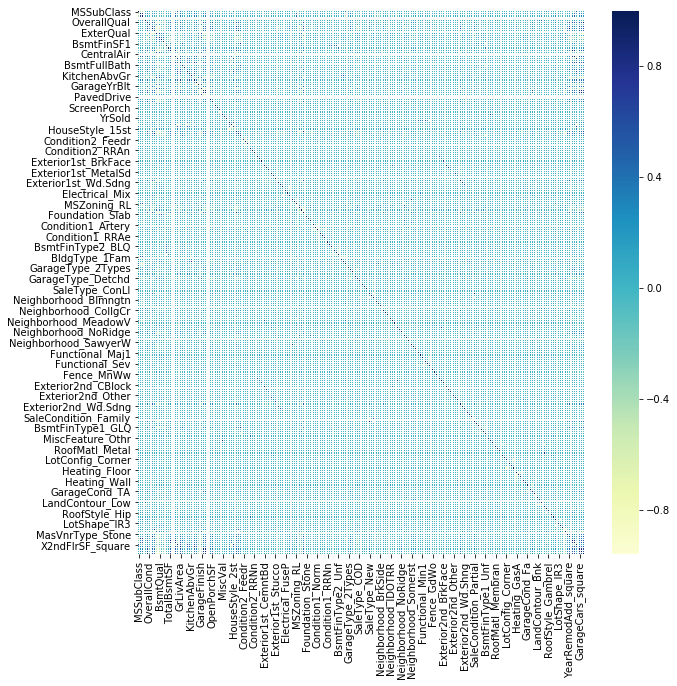

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrM,center=0,linewidths=.05,cmap="YlGnBu",ax=ax)

In [41]:
train = pd.merge(total.loc[total['Id']<=train_elem],prices,on='Id')
test = total.loc[total['Id']>train_elem]

In [45]:
temp = []
for x,y in to_delete:
    if error_calc(train[x],train['SalePrice'],True) > error_calc(train[y],train['SalePrice'],True):
        temp.append(x)
    else:
        temp.append(y)
to_delete = temp
train = train.drop(columns=to_delete)
test = test.drop(columns=to_delete)

In [46]:
col, numCol, nonNumCol = columner(test)

As we did at the beginning, there can be different spurios data. Previuosly we removed it watching the plot, but in the following part of code, we compute an "outlier test" using the OLS library. 

In [47]:
ols = sm.OLS(endog = train['SalePrice'], exog = train.drop(columns=['SalePrice','Id']))
fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']
outliers = list(test2[test2<1e-3].index)
train = train.drop(train.index[outliers])

For further clean the data, we also include an alorithm that will delete the columns with a vast majority of $0$, as they won't be very informative in our regression. On the other hand, they can give convergenze problem, so we decided to remove them.

In [48]:
constant = []
for i in col:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 >99.9:
        constant.append(i)
train = train.drop(columns=constant)
test = test.drop(columns=constant)

In [49]:
col, numCol, nonNumCol = columner(test)

Finally, we get a list of all the correlation of the different features with the *SalePrice* column.

In [50]:
corrList = correlator(train, prices['SalePrice'])
corrList

[('GrLivArea', 0.20676570645961515),
 ('KitchenQual', -0.20082738050808577),
 ('OverallQual_square', 0.19735482370315025),
 ('OverallQual', 0.19598839936577572),
 ('X1stFlrSF', 0.18486262729696126),
 ('BsmtQual', -0.1824448015561686),
 ('GarageCars', 0.18112373678917515),
 ('GarageCars_square', 0.17599698405710956),
 ('GarageArea', 0.17446986466607442),
 ('TotRmsAbvGrd', 0.17169691353863606),
 ('TotalBsmtSF', 0.16975032615298025),
 ('FullBath', 0.16766901597732572),
 ('GarageFinish', -0.16540769651759518),
 ('ExterQual', -0.1652294162480506),
 ('LotArea', 0.16241025973650958),
 ('GarageArea_square', 0.16025608192040455),
 ('TotalBsmtSF_square', 0.15483398236486876),
 ('LotFrontage', 0.1534834126581309),
 ('FireplaceQu', -0.15121139872024536),
 ('YearRemodAdd', 0.14066709975918829),
 ('Fireplaces', 0.1394053917109956),
 ('Neighborhood_NridgHt', 0.12723703396572036),
 ('YearBuilt', 0.12162872165130474),
 ('MasVnrArea', 0.11999602104286125),
 ('MSZoning_RM', -0.11935784178789938),
 ('Heat

## Modelling

Now we are ready to fit our data in a model to later do our predictions. We are going to use different models and do a weighted mean of them, and we are also going to use a different number of feature for each model.

To choose the number of features and the weights we usa a Monte Carlo cross-validation method. That is, we divide our traning set in two groups: the train set and the cross set. We will fit our model in all the different possibles way with the train set and check the results with the cross set. we repeat the process a fixed number of times and take the mean of our results.

First of all we prepare a list of models to be used, and we decide the number of samples to be used in the cross-validation Monete Carlo method.

In [51]:
# we set the number of random samples to be drawn to estimate best parameters
RCS = 200
# list of models to be used
models = [make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000)),
          Ridge(alpha=15.0, fit_intercept = True)]

We use a Lasso regression model associated with a robust scaler and a Ridge regression model.

Let us exaplain how thoses regressions work: let us fix $n$ the number of samples, $y$ the vector of training price and $X$ the matrix of traning features.

The Lasso regression model aims to minimze $\frac{1}{2n}||y - Xw||^2_2 + \alpha||w||_1$ where $\alpha$ is a parameter and $w$ the set of linear coefficent to find. The robust scaler associated to it is a normalizer function. Instead of fitting the data on the train set we normalize each feature (columns of $X$) subtracting the mean and dividing by the standard deviation. Mean and standard deviation are calculated ignoring the extreme values, to avoid interference by outliers.

The Ridge regression model aim to minimze $||y - Xw||^2_2 + \alpha||w||^2_2$ where $\alpha$ is a parameter and $w$ the set of linear coefficents to find.

### Best number of features

First of all we shall decide how many features use for each model. To do so we fit the each model with all the possible number of features, keeping inside the most correlated to the price. At each iteration we store the $RMSE$ and take as the best number of feature the one leading to the lowest $RMSE$.

In [52]:
best_k = []
for model in models:
    ks = []
    print(model)
    for _ in tqdm(range(RCS)):
        try:
            ks.append(regEstimator(*crosser(train.drop(columns=['Id'])),model,corrList,False))
        except:
            pass
    best_k.append((model,int(np.mean(ks))))

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [26:16<00:00,  7.88s/it]


Ridge(alpha=15.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:52<00:00,  1.16s/it]


### Weights evaluation

Now that we have the best number of features for each model, we need to know how to mix them to make some final predictions. To do so we try to mix them with all possible combinations of weights, and again we evaluate the $RMSE$ produced. We choose the list of weights that give the lower $RMSE$.

In [53]:
ws = list(get_tuples(len(models),100))
best_weights = []
for _ in tqdm(range(RCS)):
    best_weights.append(mixer(*crosser(train.drop(columns=['Id'])),best_k, ws,False))
best_weights = [np.mean(w) for w in zip(*best_weights)]
print(best_weights)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.62it/s]


[91.6, 8.4]


### Estimate the best value for the quantile adjustement

We want to modify the endpoint and starting point of our regression function. We will lower the value of the lowest prices and increse the value of the highest, as our models have the tendence to flatten too much the most extreme houses.

To help the immagination, let us show what that will do in a 1-feature case. Instead of having a straigth line as regression curve it will be flattened at the start and the end, as in the next images.

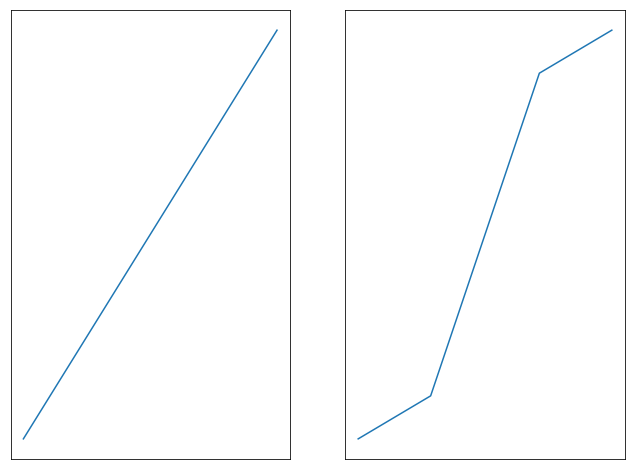

In [54]:
plotter()

To do so, first of all, we estimate the optimal parameters for this modification trying different ones with random samples and Monte Carlo cross-validation.

In [55]:
parameters = []
for _ in tqdm(range(int(RCS/20))):
    parameters.append(qEst(*crosser(train.drop(columns=['Id']))))
parameters = [np.mean(w) for w in zip(*parameters)]
print(parameters)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:24<00:00, 44.43s/it]


[0.00414, 0.9289999999999999, 0.8690000000000001, 1.0520000000000003]


## Get the predictions

At this point everything is setted up. We fit our regression model on the train set, with the number of features computed before, and predict the prices for the test model.

We then mix them using the best weights computed above.

In [56]:
predictionList = []
for model,k in best_k:
    trainFiltred_X, testFiltred = filtering(train.drop(columns=['Id','SalePrice']),test.drop(columns=['Id']),k)
    predictionList.append(model.fit(trainFiltred_X,train['SalePrice']).predict(testFiltred))

mixedPred = sum([x*np.expm1(y) for (x,y) in zip(best_weights,predictionList)])/100

We store them in a dataframe suited to be stored in a file

In [57]:
result = pd.DataFrame()
result['Id'] = [1461+i for i in range(len(mixedPred))]
result['SalePrice'] = mixedPred

We applay the quantile modification.

In [58]:
q = result['SalePrice'].describe(percentiles=parameters[:2])
q1 = q[4]
q2 = q[-2]
result['SalePrice'] = result['SalePrice'].apply(lambda x: x if x > q1 else x*parameters[2])
result['SalePrice'] = result['SalePrice'].apply(lambda x: x if x < q2 else x*parameters[3])

We import another prediction of the prices made in R using a SVM. We show here the code used.

The SVM is done using the e1071 package, whose [documentation can be found here](https://cran.r-project.org/web/packages/e1071/e1071.pdf).

We then proced to mix our actual prediction with the one made in R, multiplying them element-wise and taking the square root of the result.

In [59]:
svm_result = pd.read_csv('svm-pred.csv')
result['SalePrice'] = np.sqrt(result['SalePrice']*svm_result['x'])

Finally we export our results.

In [60]:
result.to_csv('submission.csv',sep=',', index=False)

# Functions

Here we define the functions to be used in the rest of the code

## Data preparation functions

In [2]:
# a function that return a triplet contanint the columns of a dataframe, as the numeric and non numeric columns 
def columner(df):
    col = set(df.columns)
    col.discard('Id')
    numCol = set(df._get_numeric_data().columns)
    numCol.discard('Id')
    nonNumCol = (col-numCol)
    return (col,numCol, nonNumCol)

In [3]:
# we applay the one-hot method to modify categorical variables in the colmuns in "colmuns"
def oneHotter(df, columns):
    for h in columns:
        df = pd.concat([df, pd.get_dummies(df[h], prefix=h)], axis=1)
        df = df.drop(columns=[h])
    return df

In [4]:
# we check and modify the skewed columns between the numeric one in "columns"
def deskewer(df,columns):
    columns = list(columns)
    skewed = df[columns].apply(lambda x: skew(x, nan_policy='omit'))
    skewed = list(skewed[skewed > 0.75].index)

    df[skewed] = np.log1p(df[skewed])
    
    return (df,skewed)

In [5]:
# we delete spurious annuncements in the numeric columns
def normalizer(df,columns):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        if std > 100:
            df = df.loc[df[col]<=mean+2*std]
    return df

In [6]:
# we get a ordered list of linear correlations between each columns and the prices
def correlator(df, ps):
    corrList = []
    columns = set(df.columns)
    columns.discard('Id')
    for c in columns:
        corrList.append((c,df[c].corr(ps)))
    corrList.sort(key=lambda x : np.abs(x[1]),reverse=True)
    return corrList[1:]

In [7]:
# function to transform data given a dictonary that store the transformation function
def transformer(x, d, maxv):
    try:
        return d[x]
    except KeyError:
        return maxv

## Regression functions

In [8]:
# function that divide randomly the dataframe in two:
# A set to be used for fitting
# A second set to be used for testing the fitted model
def crosser(df):
    train, cross = train_test_split(df,test_size=0.3)

    train_X = train.drop(columns=['SalePrice'])
    cross_X = cross.drop(columns=['SalePrice'])
    train_y = train['SalePrice']
    cross_y = cross['SalePrice']

    return (train_X, cross_X, train_y, cross_y)

In [9]:
# we keep only the most correlated columns of two dataframes
def filtering(g1_X,g2_X,number):
    g1Filtred_X = g1_X.filter([corrList[i][0] for i in range(number)])
    g2Filtred_X = g2_X.filter([corrList[i][0] for i in range(number)])
    return (g1Filtred_X,g2Filtred_X)

In [10]:
# we get the best number of features for a generic regression
def regEstimator(train_X,cross_X,train_y,cross_y, regressor, corrList,R2):
    valuesErrors = []
    for k in range(1,len(corrList)-1):
        trainFiltred_X,crossFiltred_X = filtering(train_X,cross_X,k) 
        try:
            reg = regressor.fit(trainFiltred_X,train_y)
            # we compute the error without the log as we already took the log of the pricies, as they're skewd
            error = error_calc(cross_y,reg.predict(crossFiltred_X),R2,k)
            valuesErrors.append((k,error))
        except ValueError:
            valuesErrors.append((k,np.infty))
    valuesErrors.sort(key = lambda x: x[1])
    return valuesErrors[0][0]

In [11]:
# we evaluete the best weights to mix different regression method
def mixer(train_X,cross_X,train_y,cross_y,regressions,weight_list, R2):
    n = len(regressions)
    predList = []
    for regressor,k in regressions:
        trainFiltred_X,crossFiltred_X = filtering(train_X,cross_X,k)
        reg = regressor.fit(trainFiltred_X,train_y)
        pred = np.expm1(reg.predict(crossFiltred_X))
        predList.append(pred)
    
    mixedValueErrors = []
    for ws in weight_list:
        mixedPred = sum([x*y for (x,y) in zip(ws,predList)])/100
        try:
            error = error_calc(cross_y,np.log1p(mixedPred),R2)
            mixedValueErrors.append((ws,error))
        except ValueError:
            mixedValueErrors.append((ws,np.infty))
    mixedValueErrors.sort(key= lambda x:x[1])
    return mixedValueErrors[0][0]

In [12]:
# we define a function to compute different type of error
def error_calc(actual_y,predicted_y,R2,adj = 1):
    if R2:
        return r2_score(actual_y,predicted_y)/adj
    else:
        return np.sqrt(mean_squared_error(actual_y,predicted_y))/adj

In [13]:
# we define a function to get all the possible touples of a fixed number of element summing to a fixed total
def get_tuples(length, total):
    if length == 1:
        yield (total,)
        return
    
    for i in range(total + 1):
        for t in get_tuples(length - 1, total - i):
            yield (i,) + t

In [14]:
# function to estimate optimal parameters for quantile correction
def qEst(train_X,cross_X,train_y,cross_y):
    predictionList = []
    for model,k in best_k:
        trainFiltred_X,crossFiltred_X = filtering(train_X,cross_X,k)
        predictionList.append(model.fit(trainFiltred_X,train_y).predict(crossFiltred_X))
    mixedPred = sum([x*np.expm1(y) for (x,y) in zip(best_weights,predictionList)])/100
    
    values = []
    for a in range(0,11):
        q1 = 0.004+(a/10000)
        for b in range(0,11):
            q2 = 0.85 + (b/100)
            for c in range(0,11):
                w1 = 0.8 + (c/100)
                for d in range(0,11):
                    w2 = 1.05 + (d/100)
                    df = pd.DataFrame()
                    df[0] = mixedPred
                    q = df[0].describe(percentiles=[q1,q2])
                    k1 = q[4]
                    k2 = q[-2]
                    df[0] = df[0].apply(lambda x: x if x > k1 else x*w1)
                    df[0] = df[0].apply(lambda x: x if x < k2 else x*w2)
    
                    try:
                        values.append(((q1,q2,w1,w2),error_calc(cross_y,np.log1p(df[0]),False)))
                        del df
                    except ValueError:
                        values.append(((q1,q2,w1,w2),np.infty))
                        del df
                    
    values.sort(key = lambda x: x[1])
    return values[0][0]

## Other functions

In [15]:
# function to make a couple of plot
def plotter():
    plt.subplot(1, 2, 1)
    plt.plot([1,2,3,4])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.plot([0.6,0.8,1,2,3,4,4.2,4.4])
    plt.xticks([])
    plt.yticks([])

In [16]:
def plotter2():
    plt.figure(figsize=(13,16))
    plt.subplot(521)
    plt.scatter(prices['SalePrice'],train['YearRemodAdd'],c='r')
    plt.xlabel('SalePrice')
    plt.ylabel('YearRemodAdd')

    plt.subplot(522)
    plt.scatter(prices['SalePrice'],train['LotFrontage'],c='yellow')
    plt.ylabel('LotFrontage')
    plt.xlabel('SalePrice')

    plt.subplot(523)
    plt.scatter(prices['SalePrice'],train['TotalBsmtSF'],c='orange')
    plt.xlabel('SalePrice')
    plt.ylabel('TotalBsmtSF')

    plt.subplot(524)
    plt.scatter(prices['SalePrice'],train['1stFlrSF'],c='orchid')
    plt.xlabel('SalePrice')
    plt.ylabel('1stFlrSF')

    plt.subplot(525)
    plt.scatter(prices['SalePrice'],train['2ndFlrSF'],c='aqua')
    plt.xlabel('SalePrice')
    plt.ylabel('2ndFlrSF')

    plt.subplot(526)
    plt.scatter(prices['SalePrice'],train['GrLivArea'], c='limegreen')
    plt.xlabel('SalePrice')
    plt.ylabel('GrLivArea')

    plt.subplot(527)
    plt.scatter(prices['SalePrice'],train['GarageCars'],c='royalblue')
    plt.xlabel('SalePrice')
    plt.ylabel('GarageCars')

    plt.subplot(528)
    plt.scatter(prices['SalePrice'],train['GarageArea'],c='lightcoral')
    plt.xlabel('SalePrice')
    plt.ylabel('GarageArea')

    plt.subplot(529)
    plt.scatter(prices['SalePrice'],train['OverallQual'],c='skyblue')
    plt.xlabel('SalePrice')
    plt.ylabel('OverallQual')

    plt.show()